In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
#!pip3 install monai

In [3]:
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import monai
import nibabel as nib
import matplotlib.pyplot as plt

In [4]:
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=1)

# Load the model from a file
MODEL_FILE = 'ct_diabetes_prediction_5yr_best.pt'
model.load_state_dict(torch.load(MODEL_FILE, map_location='cpu'))

<All keys matched successfully>

In [5]:
def preprocess(img_path):
    """
    Preprocesses the image and returns a tensor
    """
    # Load the image
    nifti_img = nib.load(img_path)
    img_data = np.array(nifti_img.dataobj, dtype=np.float32)

    # Scale the image values
    img_data = img_data / 1024.0

    # take every other slice in the z direction, in the case where the image spacing is originally 1.5mm in the z direction
    img_data = img_data[:, :, ::2]

    # Define the target size
    target_size = [250, 250, 150]

    # Check if padding is needed
    if np.any(np.array(img_data.shape) < target_size):
        pad_width = [(0, max_size - img_size) if img_size < max_size else (0, 0) for img_size, max_size in zip(img_data.shape, target_size)]
        img_data = np.pad(img_data, pad_width, mode='constant')

    # Check if cropping is needed
    if np.any(np.array(img_data.shape) > target_size):
        crop_width = [(img_size - max_size) // 2 if img_size > max_size else 0 for img_size, max_size in zip(img_data.shape, target_size)]
        img_data = img_data[crop_width[0]:crop_width[0]+target_size[0], crop_width[1]:crop_width[1]+target_size[1], crop_width[2]:crop_width[2]+target_size[2]]

    # Add batch dimension and the channel dimension
    img_data = img_data[np.newaxis, np.newaxis, :, :, :]

    # Convert to tensor
    img_data = torch.from_numpy(img_data)

    return img_data

In [7]:
img_tensor = preprocess('data/AC423c083_0000.nii.gz')

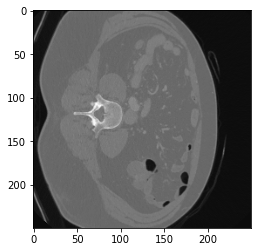

In [12]:
plt.imshow(img_tensor[0,0,:,:,75], cmap='gray')

In [13]:
logit = model(img_tensor)
print(logit)

tensor([[-0.9409]], grad_fn=<AddmmBackward0>)


In [6]:
nifti_img = nib.load('/home/users/joecohen/group/diabetes_positives_cts/positive_scans/AC423c083_0000.nii.gz')

In [13]:
list(nifti_img.header.items())

[('sizeof_hdr', array(348, dtype=int32)),
 ('data_type', array(b'', dtype='|S10')),
 ('db_name', array(b'', dtype='|S18')),
 ('extents', array(0, dtype=int32)),
 ('session_error', array(0, dtype=int16)),
 ('regular', array(b'', dtype='|S1')),
 ('dim_info', array(0, dtype=uint8)),
 ('dim', array([  3, 269, 269, 337,   1,   1,   1,   1], dtype=int16)),
 ('intent_p1', array(0., dtype=float32)),
 ('intent_p2', array(0., dtype=float32)),
 ('intent_p3', array(0., dtype=float32)),
 ('intent_code', array(0, dtype=int16)),
 ('datatype', array(4, dtype=int16)),
 ('bitpix', array(16, dtype=int16)),
 ('slice_start', array(0, dtype=int16)),
 ('pixdim', array([1. , 1.5, 1.5, 1.5, 1. , 1. , 1. , 1. ], dtype=float32)),
 ('vox_offset', array(0., dtype=float32)),
 ('scl_slope', array(nan, dtype=float32)),
 ('scl_inter', array(nan, dtype=float32)),
 ('slice_end', array(0, dtype=int16)),
 ('slice_code', array(0, dtype=uint8)),
 ('xyzt_units', array(2, dtype=uint8)),
 ('cal_max', array(0., dtype=float32)),